## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1317
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the time span of interest

In [6]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [8]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [9]:
### Process and observation noise
σx = 1e-1
σy = 1.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [23]:
# Number of runs
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 0.0

Create cache to store the different final solutions

In [37]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [87]:
J = ceil(Int64, (tf-t0)/Δtobs)
@inbounds for i=1:Ne
    xtmp = rand(π0)
    for j=1:J
        tspan = (t0 + (j-1)*model.Δtobs, t0 + j*model.Δtobs)
        prob = remake(prob, tspan = tspan, u0 = xtmp)
        sol = solve(prob, Tsit5(), dt = Δtdyn, dense = false, save_everystep = false)
        xtmp .= copy(sol.u[end]) 
        # Add process noise
        model.ϵx(xtmp)
    end
    
    # Store the state
    X[Ny+1:Ny+Nx,i] .= copy(xtmp)
end
# Generate the observations
observe(h, X, tf, Ny, Nx)

# Apply the observation noise
ϵy(X, 1, Ny)

In [90]:
S = totalordermap(X, 2; b = "CstLinProHermite")

Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 2 active features
Map component of dimension 2 with Nψ = 5 active features
Map component of dimension 3 with Nψ = 9 active features
Map component of dimension 4 with Nψ = 14 active features
Map component of dimension 5 with Nψ = 20 active features
Map component of dimension 6 with Nψ = 27 active features


In [91]:
@time optimize(S, X, nothing; withqr = true, verbose = false, hessprecond = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.847920 seconds (82.88 k allocations: 761.048 MiB, 5.03% gc time)


Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 2 active features
Map component of dimension 2 with Nψ = 5 active features
Map component of dimension 3 with Nψ = 9 active features
Map component of dimension 4 with Nψ = 14 active features
Map component of dimension 5 with Nψ = 20 active features
Map component of dimension 6 with Nψ = 27 active features


In [92]:
getcoeff(S[6])

27-element Vector{Float64}:
  10.161510671108578
  -0.2974132139826837
  -0.31731955716296173
   2.070090589225505
  -0.5239121469240571
   0.37901087734607813
  -0.3459636425633501
  -1.7256358774589464
  24.02260192014566
  -8.346613305285917
   0.9469758723859913
  -2.132016057774447
  -0.18810079368413968
   ⋮
  -2.5379838838230797
  -0.8461075195232656
   4.726332933190606
   2.6562433498265663
  -3.7583335020511317
   0.29870650993369846
   1.1865425793781255
   4.864731869945938
  -3.5282396620810204
  -0.8170918345979092
  -4.5099421920699605
 -19.71595293761949

In [93]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Matrix{Float64}:
     5.03846e8  1.58636e5  8.80774e5  …  12004.5             5.70445e5
     1.58636e5  8.66349e8  1.21268e6         8.98411e8       3.99113e5
     8.80774e5  1.21268e6  4.88079e8         5.34409e5       5.97099e8
     4.16628e8  1.4692e6   1.182e6           1.23543e8  236739.0
 12004.5        8.98411e8  5.34409e5         1.40967e9       3.24555e5
     5.70445e5  3.99113e5  5.97099e8  …      3.24555e5       9.16302e8

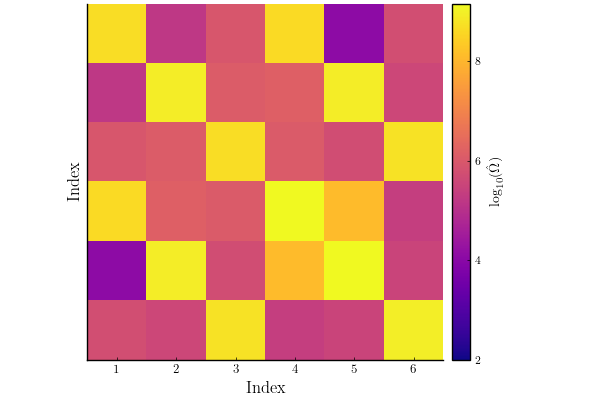

In [94]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (2.0, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

The rest is work in progress

Set initial condition of the true system

In [95]:
x0 = rand(model.π0);

In [96]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [97]:
Ne = 500 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×500 view(::Matrix{Float64}, 4:6, :) with eltype Float64:
  0.738924  -0.189782  1.40653   …   0.0492205  -1.86922  -0.942872
  1.11338    2.00116   0.823494     -0.0091012  -1.37158   1.07058
 -0.461029   0.163745  1.17638       0.351838    1.06474   0.0137872

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [98]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)
tspin = 10.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

100

In [99]:
Xspin = seqassim(F, data, Tspin, model.ϵx, enkf, deepcopy(X), model.Ny, model.Nx, t0);

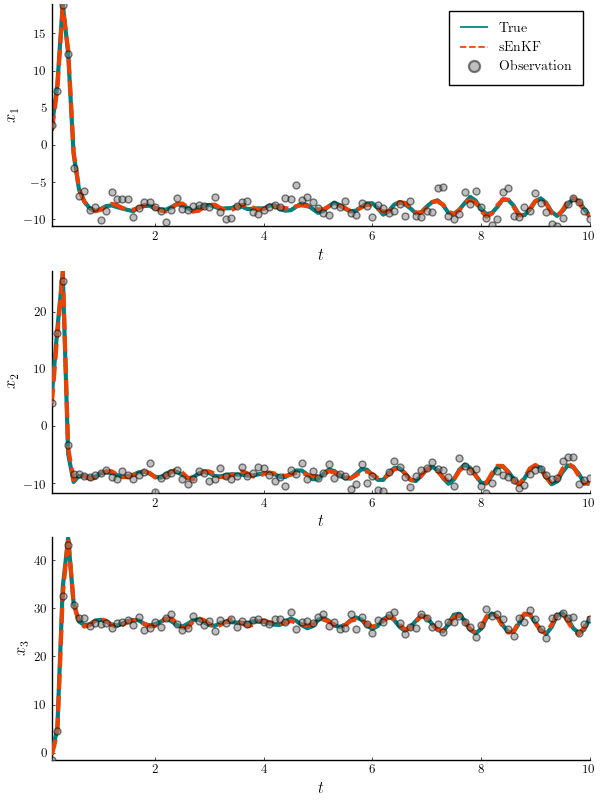

In [100]:
nb = 1
ne = Tspin
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xspin)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

Define the stochastic map filter `smf`, based on the `HermiteMap` `S`. 

In [120]:
X0 = vcat(zeros(Ny, Ne), Xspin[end])

# Add process noise
model.ϵx(X0, Ny+1, Ny+Nx)

# Generate the observations
observe(h, X0, tspin, Ny, Nx)

# Apply the observation noise
ϵy(X0, 1, Ny)

In [146]:
# m = 40
# S = HermiteMap(m, X0; diag = true, b = "CstLinProHermite")

S = totalordermap(X0, 1; b = "CstLinProHermite")

Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 1 active features
Map component of dimension 2 with Nψ = 2 active features
Map component of dimension 3 with Nψ = 3 active features
Map component of dimension 4 with Nψ = 4 active features
Map component of dimension 5 with Nψ = 5 active features
Map component of dimension 6 with Nψ = 6 active features


In [147]:
# @time optimize(S, X0, "kfolds"; withqr = true, verbose = true, hessprecond = true, start = Ny+1)
@time optimize(S, X0, nothing; withqr = true, verbose = true, hessprecond = true, start = Ny+1)

  0.013960 seconds (5.88 k allocations: 21.725 MiB)


Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 1 active features
Map component of dimension 2 with Nψ = 2 active features
Map component of dimension 3 with Nψ = 3 active features
Map component of dimension 4 with Nψ = 4 active features
Map component of dimension 5 with Nψ = 5 active features
Map component of dimension 6 with Nψ = 6 active features


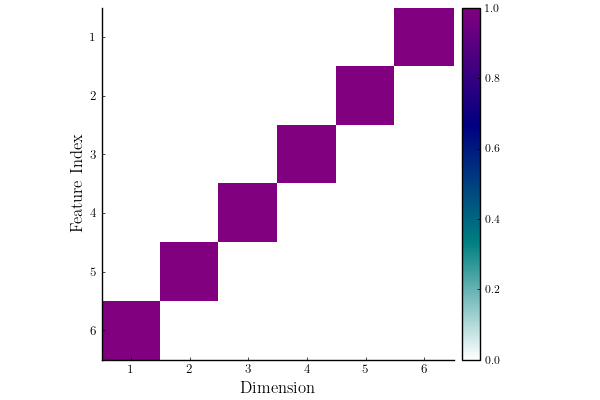

In [148]:
plot(S[6].I.f)

In [149]:
smf = FixedOrderStochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, 4*Δtobs, false)

Fixed Order Stochastic Map Filter with filtered = false


In [135]:
mean(evaluate(S, X0; start = Ny+1); dims = 2)

6×1 Matrix{Float64}:
  0.0
  0.0
  0.0
  8.198552947646931e-15
  2.347499972188416e-14
 -4.942801723473167e-14

In [136]:
cov(evaluate(S, X0; start = Ny+1); dims = 2)

6×6 Matrix{Float64}:
 0.0  0.0  0.0   0.0         0.0          0.0
 0.0  0.0  0.0   0.0         0.0          0.0
 0.0  0.0  0.0   0.0         0.0          0.0
 0.0  0.0  0.0   1.002       1.20419e-6  -1.52694e-6
 0.0  0.0  0.0   1.20419e-6  1.002        2.01263e-6
 0.0  0.0  0.0  -1.52694e-6  2.01263e-6   1.002

In [137]:
Sxpush = evaluate(S, X0; start = Ny+1)[Ny+1:end,:]

3×500 Matrix{Float64}:
  1.11501   -0.26072    -0.289983  …   0.773296  1.42545  -0.459087
  0.470358  -0.0018438  -0.428578     -1.1821    1.36603  -1.06046
 -0.859717  -0.759355   -0.427835     -0.420274  1.49374  -1.18681

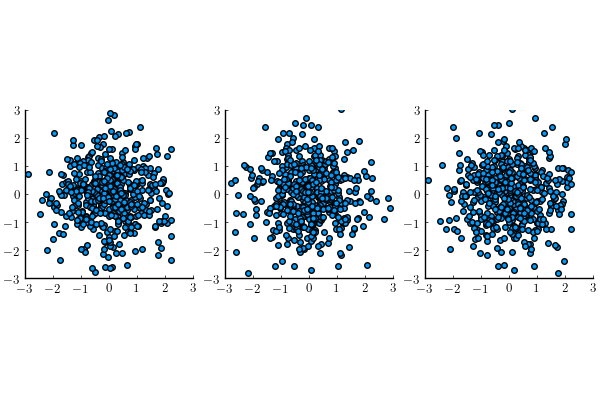

In [138]:
plt = plot(layout = grid(1,3), xlim = (-3, 3), ylim = (-3,3), legend = false)
    scatter!(plt[1,1], Sxpush[1,:], Sxpush[2,:], ratio = 1)
    scatter!(plt[1,2], Sxpush[2,:], Sxpush[3,:], ratio = 1)
    scatter!(plt[1,3], Sxpush[1,:], Sxpush[3,:], ratio = 1)
plt

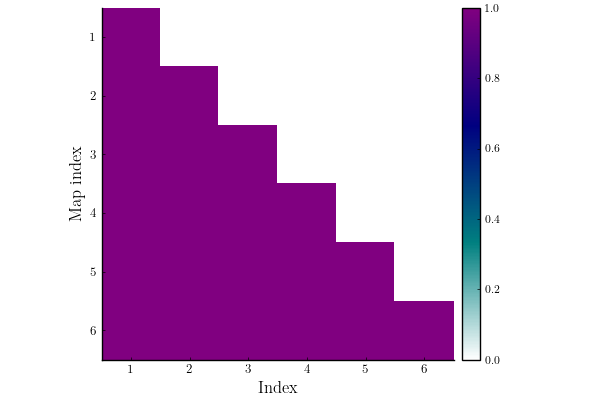

In [139]:
plot(S)

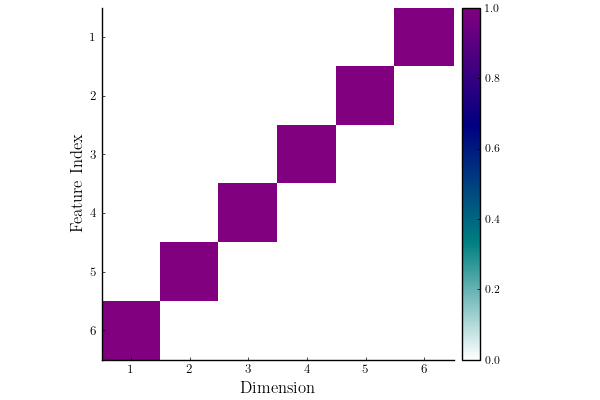

In [140]:
plot(S.C[6].I.f)

In [145]:
smf.M[6].I.f.B

MultiBasis(Basis of 4 functions: Constant, Linear, 0th -> 1th degree Probabilistic Hermite function
, 6)

In [142]:
Xsmf = seqassim(F, data, 100, model.ϵx, smf, deepcopy(vcat(zeros(Ny, Ne), Xspin[end])), model.Ny, model.Nx, tspin)

101-element Vector{Matrix{Float64}}:
 [-9.410270363618578 -9.577692456467723 … -9.36129523358093 -9.766740481941865; -9.51421549208296 -9.949142975032306 … -9.130481594743928 -10.160367831207193; 27.952751667326826 28.163029974821207 … 28.38692196660916 27.883105876153778]
 [-9.219808651259896 -9.328775088109854 … -8.964983292111834 -9.406378450731887; -8.22384852626932 -8.319618259028442 … -7.917640929071894 -8.570459786084566; 28.846039343615292 29.29280421349398 … 28.601131759797386 29.427013963865488]
 [-8.347365807164563 -8.126108101202007 … -8.038863526579622 -8.363661271143538; -6.981112938701046 -6.847839923060001 … -7.199707738796518 -6.803258738849004; 27.637319747362348 28.023383685687055 … 27.33123766947923 28.559749172513406]
 [-7.598490729907352 -7.18178297279525 … -7.634003715718821 -7.225236690054522; -7.205597347590722 -6.960965695426565 … -7.462040623327214 -6.323951528569556; 26.17875888782061 25.948682770684314 … 26.046642544989442 26.371488138595517]
 [-7.750429890

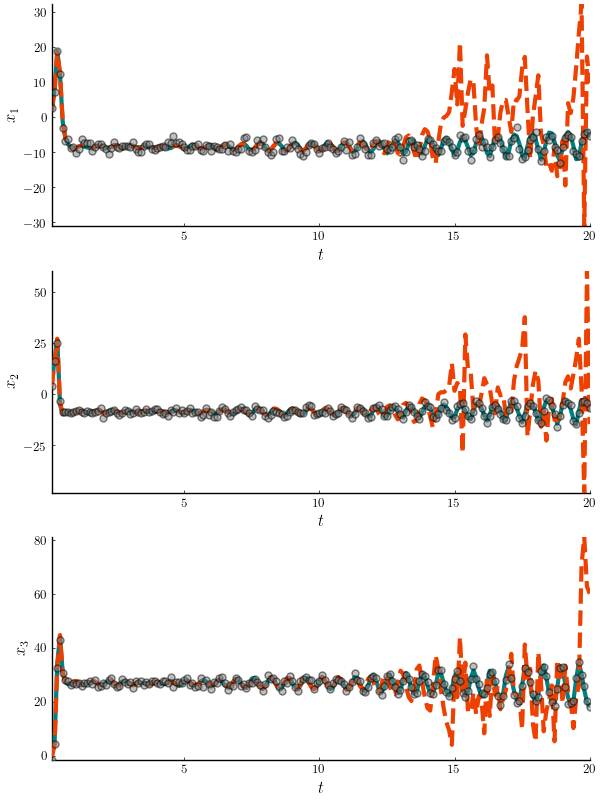

In [144]:
nb = 1
ne = Tspin+100
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = false, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xspin, Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

# savefig("lorenz63_kfoldoptim.pdf")

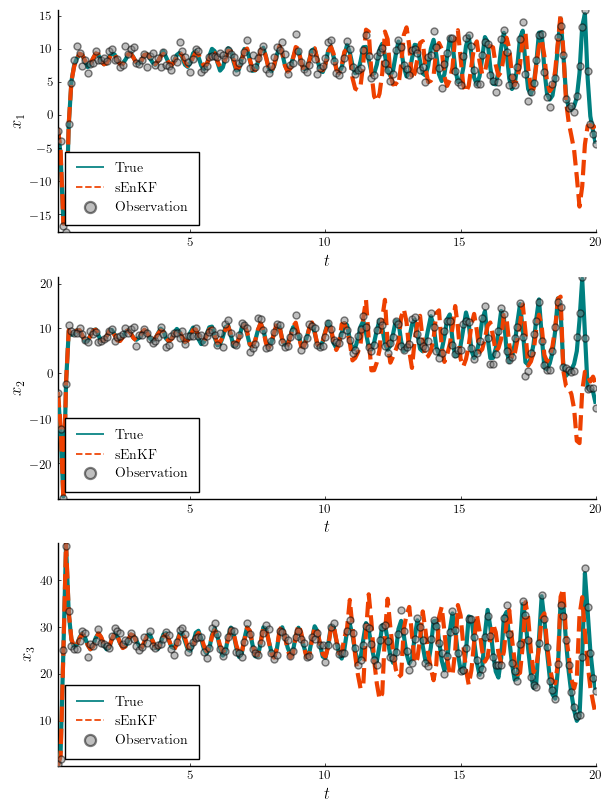

┌ Warning: /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent is not an existing directory, Revise is not watching
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:565


In [127]:
nb = 1
ne = Tspin+100
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xspin, Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

# savefig("lorenz63.pdf")

In [77]:
vcat(Xspin, Xsmf)

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [133]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×101 Array{Float64,2} at index [1, 2:1:500][39m

In [69]:
Xsmf

┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl:4", UndefVarError(:TYPEDEF), Any[(top-level scope at system.jl:4, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl:52", UndefVarError(:TYPEDFIELDS), Any[(top-level scope at inflation.jl:52, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl:3", UndefVarError(:TYPEDSIGNATURES), Any[(top-level scope at etkf.jl:3, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Erro

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.